# Lab 02: Feature Engineering - Baseline 
---

# 1. Giới Thiệu

Ở notebook này, nhóm sẽ thực hiện **Feature Engineering** để cải thiện hiệu suất của mô hình Softmax Regression. Nhóm thiết kế và so sánh **6 biểu diễn đặc trưng khác nhau** của các chữ số MNIST:

1. **Phương án 1 (Baseline):** Pixel Thô (784 đặc trưng)
2. **Phương án 2:** Average Pooling (49 đặc trưng) - Giảm chiều
3. **Phương án 3:** Sobel Edge Detection (784 đặc trưng) - Phát hiện cạnh
4. **Phương án 4:** PCA - Principal Component Analysis (80 đặc trưng)
5. **Phương án 5:** Rotation Invariance (784 đặc trưng) - Xoay chữ số upright
6. **Phương án 6:** HOG - Histogram of Oriented Gradients (81 đặc trưng)

Mục tiêu: Xác định phương án nào cho hiệu suất tốt nhất trên tập dữ liệu MNIST.

## 1.1. Setup và import thư viện

In [1]:
import sys
import os
sys.path.insert(0, '../lib')

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from SoftmaxRegression import SoftmaxRegression
from helpers import load_mnist_data, one_hot_encode, compute_metrics, plot_confusion_matrix

# Thiết lập random seed cho tái lập
np.random.seed(42)

print("Tải thư viện thành công !")

Tải thư viện thành công !


In [2]:
# --- TẢI DỮ LIỆU MNIST ---
print("Đang tải dữ liệu MNIST...")
X_train_raw, y_train, X_test_raw, y_test = load_mnist_data(data_path='../data/raw/mnist.npz')

# Mã hóa One-Hot cho nhãn
y_train_enc = one_hot_encode(y_train, num_classes=10)
y_test_enc = one_hot_encode(y_test, num_classes=10)

print(f"\n Dữ liệu đã tải:")
print(f"   X_train_raw shape: {X_train_raw.shape} ")
print(f"   y_train shape: {y_train.shape} ")
print(f"   X_test_raw shape:  {X_test_raw.shape} (10,000 mẫu × 784 features)")
print(f"   y_test shape:  {y_test.shape} (10,000 nhãn)")

# Reshape lại thành ảnh (28, 28) để xử lý đặc trưng
X_train_img = X_train_raw.reshape(-1, 28, 28)
X_test_img = X_test_raw.reshape(-1, 28, 28)

print(f"\n Ảnh đã reshape:")
print(f"   X_train_img shape: {X_train_img.shape}")
print(f"   X_test_img shape:  {X_test_img.shape}")

# Dictionary lưu kết quả
results = {}
trained_models = {}
classes = list(range(10))

Đang tải dữ liệu MNIST...

 Dữ liệu đã tải:
   X_train_raw shape: (60000, 784) 
   y_train shape: (60000,) 
   X_test_raw shape:  (10000, 784) (10,000 mẫu × 784 features)
   y_test shape:  (10000,) (10,000 nhãn)

 Ảnh đã reshape:
   X_train_img shape: (60000, 28, 28)
   X_test_img shape:  (10000, 28, 28)


# 2. Phương Án 1: Pixel Thô (Baseline)


## 2.1. Khái Niệm

**Baseline** là phương án đơn giản nhất: sử dụng trực tiếp giá trị pixel đã chuẩn hóa từ ảnh gốc.

- **Kích thước đặc trưng:** 28 × 28 = **784 đặc trưng**
- **Quá trình:** Flatten ảnh thành vector 1D
- **Công thức:** $(28, 28) \rightarrow (784,)$

## 2.2. Cơ sở toán Học

Giả sử ảnh gốc là ma trận $I \in \mathbb{R}^{28 \times 28}$, đặc trưng baseline là:
$$\mathbf{x} = \text{flatten}(I) \in \mathbb{R}^{784}$$

Không có biến đổi hay xử lý gì, chỉ reshape từ 2D sang 1D.

## 2.3. Ưu Điểm
✅ Giữ lại **toàn bộ thông tin** của ảnh  
✅ Không tốn chi phí thời gian xử lý (chỉ flatten)  
✅ Dễ hiểu và triển khai  
✅ Dùng làm mốc so sánh (baseline)

## 2.4. Nhược Điểm
❌ **Số chiều đầu vào lớn:** 784 đặc trưng → Mô hình nặng, training chậm  
❌ **Nhạy cảm với nhiễu:** Các pixel nền được coi ngang bằng pixel viết  
❌ **Không robust:** Nhạy cảm với các phép biến đổi hình học nhỏ (dịch chuyển, xoay)  
❌ **Redundancy:** Các pixel lân cận thường tương quan cao  

## 2.5. Kỳ Vọng Hiệu Suất
**Accuracy dự kiến:** ~92-93% (Đây sẽ là mốc so sánh)

## 2.6 Baseline Feature Extraction

In [3]:
def extract_baseline_features(X_img):
    """
    Trích xuất đặc trưng Baseline (Pixel Thô).
    
    Công thức: Đơn giản flatten ảnh từ (28, 28) -> (784,)
    
    Args:
        X_img (np.ndarray): Ảnh input, shape (N, 28, 28), giá trị [0, 1]
    
    Returns:
        np.ndarray: Ma trận đặc trưng, shape (N, 784)
    
    Notes:
        - Không có xử lý thêm, chỉ reshape
        - Toàn bộ thông tin pixel được giữ lại
    """
    N = X_img.shape[0]
    return X_img.reshape(N, -1)

# Áp dụng cho tập train và test
print("\n" + "="*70)
print("PHƯƠNG ÁN 1: BASELINE (PIXEL THÔ)")
print("="*70)

X_train_baseline = extract_baseline_features(X_train_img)
X_test_baseline = extract_baseline_features(X_test_img)

print(f"\n Baseline Features Extracted:")
print(f"   X_train_baseline: {X_train_baseline.shape}")
print(f"   X_test_baseline:  {X_test_baseline.shape}")
print(f"   Min value: {X_train_baseline.min():.4f}")
print(f"   Max value: {X_train_baseline.max():.4f}")
print(f"   Không có xử lý, chỉ flatten ảnh 28×28 thành 784 features")


PHƯƠNG ÁN 1: BASELINE (PIXEL THÔ)

 Baseline Features Extracted:
   X_train_baseline: (60000, 784)
   X_test_baseline:  (10000, 784)
   Min value: 0.0000
   Max value: 1.0000
   Không có xử lý, chỉ flatten ảnh 28×28 thành 784 features


### 2.6.1. Hyperparameter Tuning: Batch Size & Learning Rate

In [15]:
# Chia tập validation từ tập training
def train_test_split(X, y, test_size=5000, random_state=42):
    """
    Chia tập dữ liệu thành train và validation.
    
    Args:
        X: Dữ liệu input, shape (N, features)
        y: Nhãn, shape (N, num_classes)
        test_size: Số lượng mẫu cho validation set
        random_state: Random seed
    
    Returns:
        X_train, X_val, y_train, y_val
    """
    np.random.seed(random_state)
    N = X.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    # Chọn test_size mẫu đầu tiên làm validation
    val_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

# Thực hiện chia tập
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_baseline, y_train_enc, 
    test_size=5000, 
    random_state=42
)

print(f"\n Chia tập Training & Validation:")
print(f"   X_train_base: {X_train_base.shape}")
print(f"   X_val_base:   {X_val_base.shape}")
print(f"   X_test_baseline: {X_test_baseline.shape}")


 Chia tập Training & Validation:
   X_train_base: (55000, 784)
   X_val_base:   (5000, 784)
   X_test_baseline: (10000, 784)


In [16]:
# Grid Search: Thử nhiều kombinasi batch_size và learning_rate
import pandas as pd

# Định nghĩa hyperparameters cần thử
batch_sizes = [32, 64, 128, 256, 512]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]

# Lưu kết quả
tuning_results = []

print("\n" + "="*70)
print("HYPERPARAMETER TUNING: Batch Size & Learning Rate")
print("="*70)

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\n Thử: batch_size={batch_size}, learning_rate={lr}")
        
        # Khởi tạo mô hình
        model = SoftmaxRegression(
            n_features=X_train_base.shape[1],
            n_classes=10,
            learning_rate=lr
        )
        
        # Huấn luyện
        start = time.time()
        model.fit(
            X_train_base, 
            y_train_base, 
            epochs=50,  # Dùng 50 epochs để test nhanh
            batch_size=batch_size, 
            verbose=False
        )
        training_time = time.time() - start
        
        # Đánh giá trên Validation set
        y_val_pred = model.predict(X_val_base)
        
        # Tính accuracy thủ công (không dùng compute_metrics nếu nó dùng sklearn)
        val_accuracy = np.mean(y_val_pred == np.argmax(y_val_base, axis=1))
        
        # Lưu kết quả
        tuning_results.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_loss': model.losses[-1]
        })
        
        print(f"   Val Accuracy: {val_accuracy*100:.2f}% | Time: {training_time:.2f}s | Loss: {model.losses[-1]:.4f}")

# Chuyển thành list of dict để dễ xem
print("\n" + "="*70)
print("KẾT QUẢ HYPERPARAMETER TUNING")
print("="*70)

# In header
print(f"{'batch_size':<12} {'learning_rate':<15} {'val_accuracy':<15} {'training_time':<15} {'final_loss':<15}")
print("-" * 75)

# In từng dòng
for result in tuning_results:
    print(f"{result['batch_size']:<12} {result['learning_rate']:<15.3f} {result['val_accuracy']*100:<15.2f} {result['training_time']:<15.2f} {result['final_loss']:<15.4f}")

# Tìm best hyperparameters
best_result = max(tuning_results, key=lambda x: x['val_accuracy'])

print(f"\n Hyperparameters Tốt Nhất:")
print(f"   Batch Size:    {best_result['batch_size']}")
print(f"   Learning Rate: {best_result['learning_rate']}")
print(f"   Val Accuracy:  {best_result['val_accuracy']*100:.2f}%")
print(f"   Training Time: {best_result['training_time']:.2f}s")


HYPERPARAMETER TUNING: Batch Size & Learning Rate

 Thử: batch_size=32, learning_rate=0.001
   Val Accuracy: 90.14% | Time: 18.87s | Loss: 0.3568

 Thử: batch_size=32, learning_rate=0.01
   Val Accuracy: 92.08% | Time: 18.07s | Loss: 0.2724

 Thử: batch_size=32, learning_rate=0.05
   Val Accuracy: 92.78% | Time: 17.76s | Loss: 0.2485

 Thử: batch_size=32, learning_rate=0.1
   Val Accuracy: 92.28% | Time: 18.76s | Loss: 0.2434

 Thử: batch_size=32, learning_rate=0.5
   Val Accuracy: 91.34% | Time: 18.06s | Loss: 0.2674

 Thử: batch_size=64, learning_rate=0.001
   Val Accuracy: 88.86% | Time: 15.39s | Loss: 0.4069

 Thử: batch_size=64, learning_rate=0.01
   Val Accuracy: 91.74% | Time: 15.29s | Loss: 0.2893

 Thử: batch_size=64, learning_rate=0.05
   Val Accuracy: 92.54% | Time: 15.13s | Loss: 0.2565

 Thử: batch_size=64, learning_rate=0.1
   Val Accuracy: 92.62% | Time: 15.07s | Loss: 0.2483

 Thử: batch_size=64, learning_rate=0.5
   Val Accuracy: 90.92% | Time: 15.48s | Loss: 0.2483



## 2.7 Huấn luyện và đánh giá Baseline

In [18]:
import time

print("\n Đang huấn luyện mô hình Baseline...")

# Khởi tạo mô hình
model_baseline = SoftmaxRegression(
    n_features=X_train_baseline.shape[1],
    n_classes=10,
    learning_rate=0.05
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_baseline.fit(
    X_train_baseline, 
    y_train_enc, 
    epochs=100, 
    batch_size=32, 
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_baseline = model_baseline.predict(X_test_baseline)
metrics_baseline = compute_metrics(y_test, y_pred_baseline, num_classes=10)

# Thêm runtime vào metrics
metrics_baseline['runtime'] = training_time

print(f"\n Kết Quả Baseline:")
print(f"   Accuracy:  {metrics_baseline['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_baseline['precision']:.4f}")
print(f"   Recall:    {metrics_baseline['recall']:.4f}")
print(f"   F1-Score:  {metrics_baseline['f1_score']:.4f}")
print(f"   Runtime:  {metrics_baseline['runtime']:.2f}s")

# Lưu kết quả
results["1. Baseline (Pixel Thô)"] = metrics_baseline
trained_models["1. Baseline (Pixel Thô)"] = model_baseline


 Đang huấn luyện mô hình Baseline...
Epoch 10/100 - Loss: 0.2755
Epoch 20/100 - Loss: 0.2615
Epoch 30/100 - Loss: 0.2550
Epoch 40/100 - Loss: 0.2507
Epoch 50/100 - Loss: 0.2477
Epoch 60/100 - Loss: 0.2451
Epoch 70/100 - Loss: 0.2431
Epoch 80/100 - Loss: 0.2417
Epoch 90/100 - Loss: 0.2401
Epoch 100/100 - Loss: 0.2386

 Đánh giá trên tập Test...

 Kết Quả Baseline:
   Accuracy:  92.60%
   Precision: 0.9250
   Recall:    0.9250
   F1-Score:  0.9249
   Runtime:  40.23s


# 3. Phương Án 2: Average Pooling (Giảm Chiều Không Gian)

## 3.1. Khái Niệm

**Average Pooling** là kỹ thuật **Giảm Chiều Không Gian (Spatial Dimensionality Reduction)**.

**Cơ Chế:**
1. Chia ảnh 28×28 thành các khối (blocks) không gian kích thước 4×4
2. Tính giá trị **trung bình** của tất cả pixel trong mỗi khối
3. Kết quả: Ảnh được nén thành lưới 7×7 = **49 đặc trưng**

**Quá trình:**
$(28, 28) \xrightarrow{\text{Pool 4×4}} (7, 7) \rightarrow (49,)$

## 3.2. Cơ Sở Toán Học

**Công thức Average Pooling:**

Cho một khối pixel kích thước $K \times K$, giá trị pooled được tính:

$$y[i,j] = \frac{1}{K^2} \sum_{a=0}^{K-1} \sum_{b=0}^{K-1} x[iK+a, jK+b]$$

Trong đó:
- $K=4$ (mặc định) là kích thước kernel pooling
- $(i, j)$ là chỉ số của khối trong lưới 7×7
- $x$ là ảnh gốc 28×28
- $y$ là ảnh sau pooling 7×7

**Ví dụ Minh Họa:**

Một khối 4×4 pixel:
$$\begin{bmatrix} 
0.1 & 0.2 & 0.3 & 0.4 \\
0.5 & 0.6 & 0.7 & 0.8 \\
0.2 & 0.3 & 0.4 & 0.5 \\
0.6 & 0.7 & 0.8 & 0.9
\end{bmatrix} 
\xrightarrow{\text{Average}}
\frac{0.1+0.2+...+0.9}{16} = 0.5$$

Cả ảnh 28×28 → 49 giá trị trung bình

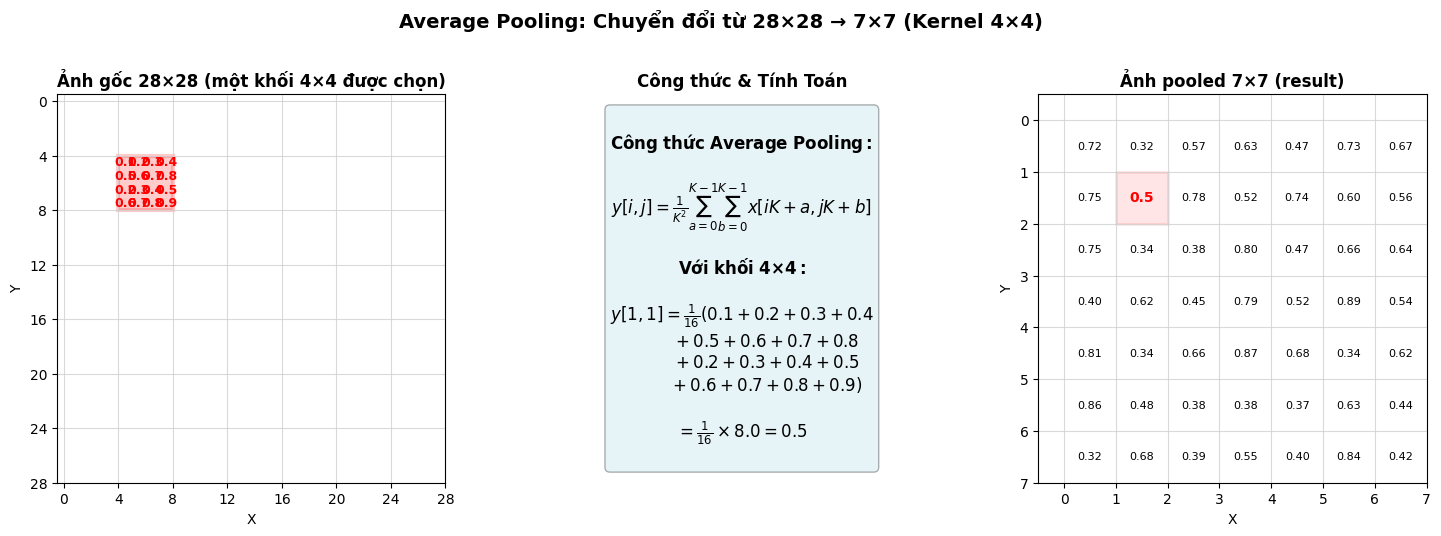


Minh họa Average Pooling:
- Ảnh gốc 28×28 được chia thành 7×7 khối (mỗi khối 4×4 pixel)
- Mỗi khối được tính trung bình thành 1 giá trị
- Ví dụ: Khối tại vị trí (1,1) có giá trị trung bình = 0.5
- Kết quả: Ảnh pooled 7×7 = 49 đặc trưng


In [12]:
# Vẽ minh họa công thức Average Pooling
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ===== HÌNH 1: Ảnh gốc 28×28 với một khối 4×4 được highlight =====
ax1 = axes[0]
ax1.set_xlim(-0.5, 28)
ax1.set_ylim(28, -0.5)  # Đảo ngược để Y từ trên xuống dưới
ax1.set_aspect('equal')

# Vẽ lưới 28×28
for i in range(0, 29, 4):
    ax1.axhline(y=i, color='lightgray', linewidth=0.5)
    ax1.axvline(x=i, color='lightgray', linewidth=0.5)

# Vẽ một khối 4×4 được highlight
rect1 = patches.Rectangle((4, 4), 4, 4, linewidth=3, edgecolor='red', facecolor='red', alpha=0.2)
ax1.add_patch(rect1)

# Điền giá trị pixel trong khối 4×4
pixel_values = np.array([[0.1, 0.2, 0.3, 0.4],
                         [0.5, 0.6, 0.7, 0.8],
                         [0.2, 0.3, 0.4, 0.5],
                         [0.6, 0.7, 0.8, 0.9]])

for i in range(4):
    for j in range(4):
        ax1.text(4.5+j, 4.5+i, f'{pixel_values[i, j]:.1f}', 
                ha='center', va='center', fontsize=9, fontweight='bold', color='red')

ax1.set_xticks(range(0, 29, 4))
ax1.set_yticks(range(0, 29, 4))
ax1.set_title('Ảnh gốc 28×28 (một khối 4×4 được chọn)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True, alpha=0.3)

# ===== HÌNH 2: Công thức tính trung bình =====
ax2 = axes[1]
ax2.axis('off')

formula_text = r"""
$\mathbf{Công\ thức\ Average\ Pooling:}$

$y[i,j] = \frac{1}{K^2} \sum_{a=0}^{K-1} \sum_{b=0}^{K-1} x[iK+a, jK+b]$

$\mathbf{Với\ khối\ 4×4:}$

$y[1,1] = \frac{1}{16}(0.1 + 0.2 + 0.3 + 0.4$
$\quad\quad\quad + 0.5 + 0.6 + 0.7 + 0.8$
$\quad\quad\quad + 0.2 + 0.3 + 0.4 + 0.5$
$\quad\quad\quad + 0.6 + 0.7 + 0.8 + 0.9)$

$= \frac{1}{16} \times 8.0 = 0.5$
"""

ax2.text(0.5, 0.5, formula_text, 
         transform=ax2.transAxes,
         fontsize=12,
         verticalalignment='center',
         horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
         family='monospace')

ax2.set_title('Công thức & Tính Toán', fontsize=12, fontweight='bold')

# ===== HÌNH 3: Ảnh pooled 7×7 =====
ax3 = axes[2]
ax3.set_xlim(-0.5, 7)
ax3.set_ylim(7, -0.5)
ax3.set_aspect('equal')

# Vẽ lưới 7×7
for i in range(8):
    ax3.axhline(y=i, color='lightgray', linewidth=0.5)
    ax3.axvline(x=i, color='lightgray', linewidth=0.5)

# Điền giá trị pooled (mỗi ô = trung bình của khối 4×4)
for i in range(7):
    for j in range(7):
        if i == 1 and j == 1:
            ax3.text(j+0.5, i+0.5, '0.5', 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='red')
            # Highlight ô này
            rect3 = patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='red', 
                                     facecolor='red', alpha=0.1)
            ax3.add_patch(rect3)
        else:
            value = np.random.uniform(0.3, 0.9)
            ax3.text(j+0.5, i+0.5, f'{value:.2f}', 
                    ha='center', va='center', fontsize=8)

ax3.set_xticks(range(8))
ax3.set_yticks(range(8))
ax3.set_title('Ảnh pooled 7×7 (result)', fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True, alpha=0.3)

plt.suptitle('Average Pooling: Chuyển đổi từ 28×28 → 7×7 (Kernel 4×4)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nMinh họa Average Pooling:")
print("- Ảnh gốc 28×28 được chia thành 7×7 khối (mỗi khối 4×4 pixel)")
print("- Mỗi khối được tính trung bình thành 1 giá trị")
print("- Ví dụ: Khối tại vị trí (1,1) có giá trị trung bình = 0.5")
print("- Kết quả: Ảnh pooled 7×7 = 49 đặc trưng")

## 3.3. Ưu Điểm

✅ **Giảm chiều đáng kể:** 784 → 49 đặc trưng (giảm **16 lần**)  
✅ **Training nhanh hơn:** Ma trận trọng số W chỉ còn (49×10) thay vì (784×10)  
✅ **Giảm Overfitting:** Hoạt động như một dạng regularization (làm mịn chi tiết)  
✅ **Bảo toàn bố cục không gian:** Cấu trúc hình học tổng quát vẫn được giữ lại  
✅ **Tiết kiệm bộ nhớ:** Model nhẹ hơn 16 lần

## 3.4. Nhược Điểm

❌ **Mất thông tin chi tiết:** Các nét nhỏ, góc cạnh tinh tế bị xóa (làm mịn)  
❌ **Khó phân biệt các chữ số tương tự:** Ảnh 7×7 quá thô, các số như 3 vs 8, 6 vs 9 khó phân biệt  
❌ **Quá mức nén:** Lưới 7×7 = 49 pixel không đủ để giữ được các chi tiết quan trọng  
❌ **Mất tính định vị:** Vị trí chính xác của các nét viết bị mờ đi

## 3.5. Kỳ Vọng Hiệu Suất

**Accuracy dự kiến:** ~88-90%

**Lý do dự đoán thấp hơn Baseline:**
- Mất quá nhiều thông tin do nén 16 lần
- Lưới 7×7 không đủ phân giải để phân biệt các chữ số phức tạp
- Tuy nhiên, tốc độ training sẽ **nhanh hơn rất nhiều** do số features ít

## 3.6. Pooling Feature Extraction

In [5]:
def extract_pooling_features(X_img, pool_size=4):
    """
    Trích xuất đặc trưng thông qua Average Pooling.
    
    Cơ Chế: Chia ảnh thành khối pool_size x pool_size và tính trung bình mỗi khối.
    
    Công thức Pooling: Được đề cập ở trên cơ sở toán học 
    
    Args:
        X_img (np.ndarray): Ảnh input, shape (N, 28, 28), giá trị [0, 1]
        pool_size (int): Kích thước kernel pooling. Mặc định: 4
    
    Returns:
        np.ndarray: Ma trận đặc trưng, shape (N, 49) khi pool_size=4
    
    Mathematical Details:
        - Input size: 28 × 28
        - Pool kernel: 4 × 4
        - Output size: 28/4 × 28/4 = 7 × 7 = 49 features
    
    Notes:
        - Giảm chiều 16 lần so với Baseline
        - Hoạt động như một dạng regularization
        - Mất chi tiết nhưng giữ bố cục tổng quát
    """
    N, H, W = X_img.shape
    
    # Kiểm tra xem H, W có chia hết cho pool_size không
    assert H % pool_size == 0 and W % pool_size == 0, \
        f"Kích thước ảnh ({H}, {W}) phải chia hết cho pool_size ({pool_size})"
    
    new_H = H // pool_size
    new_W = W // pool_size
    
    # Reshape để có thể tính mean dễ dàng
    # (N, 28, 28) -> (N, 7, 4, 7, 4)
    X_reshaped = X_img.reshape(N, new_H, pool_size, new_W, pool_size)
    
    # Tính trung bình theo chiều pool (axis 2 và 4)
    # (N, 7, 4, 7, 4) -> (N, 7, 7)
    X_pooled = X_reshaped.mean(axis=(2, 4))
    
    # Flatten thành vector
    # (N, 7, 7) -> (N, 49)
    return X_pooled.reshape(N, -1)

# Áp dụng cho tập train và test
print("\n" + "="*70)
print("PHƯƠNG ÁN 2: AVERAGE POOLING (7×7)")
print("="*70)

X_train_pool = extract_pooling_features(X_train_img, pool_size=4)
X_test_pool = extract_pooling_features(X_test_img, pool_size=4)

print(f"\n Pooling Features Extracted:")
print(f"   X_train_pool: {X_train_pool.shape}")
print(f"   X_test_pool:  {X_test_pool.shape}")
print(f"   Giảm chiều: {784}/{X_train_pool.shape[1]} = {784/X_train_pool.shape[1]:.1f}× nhỏ hơn Baseline")
print(f"   Min value: {X_train_pool.min():.4f}")
print(f"   Max value: {X_train_pool.max():.4f}")


PHƯƠNG ÁN 2: AVERAGE POOLING (7×7)

 Pooling Features Extracted:
   X_train_pool: (60000, 49)
   X_test_pool:  (10000, 49)
   Giảm chiều: 784/49 = 16.0× nhỏ hơn Baseline
   Min value: 0.0000
   Max value: 1.0000


## 3.6. Trực Quan Hóa Kết Quả Pooling

So sánh ảnh gốc và ảnh sau khi áp dụng Average Pooling 4×4:

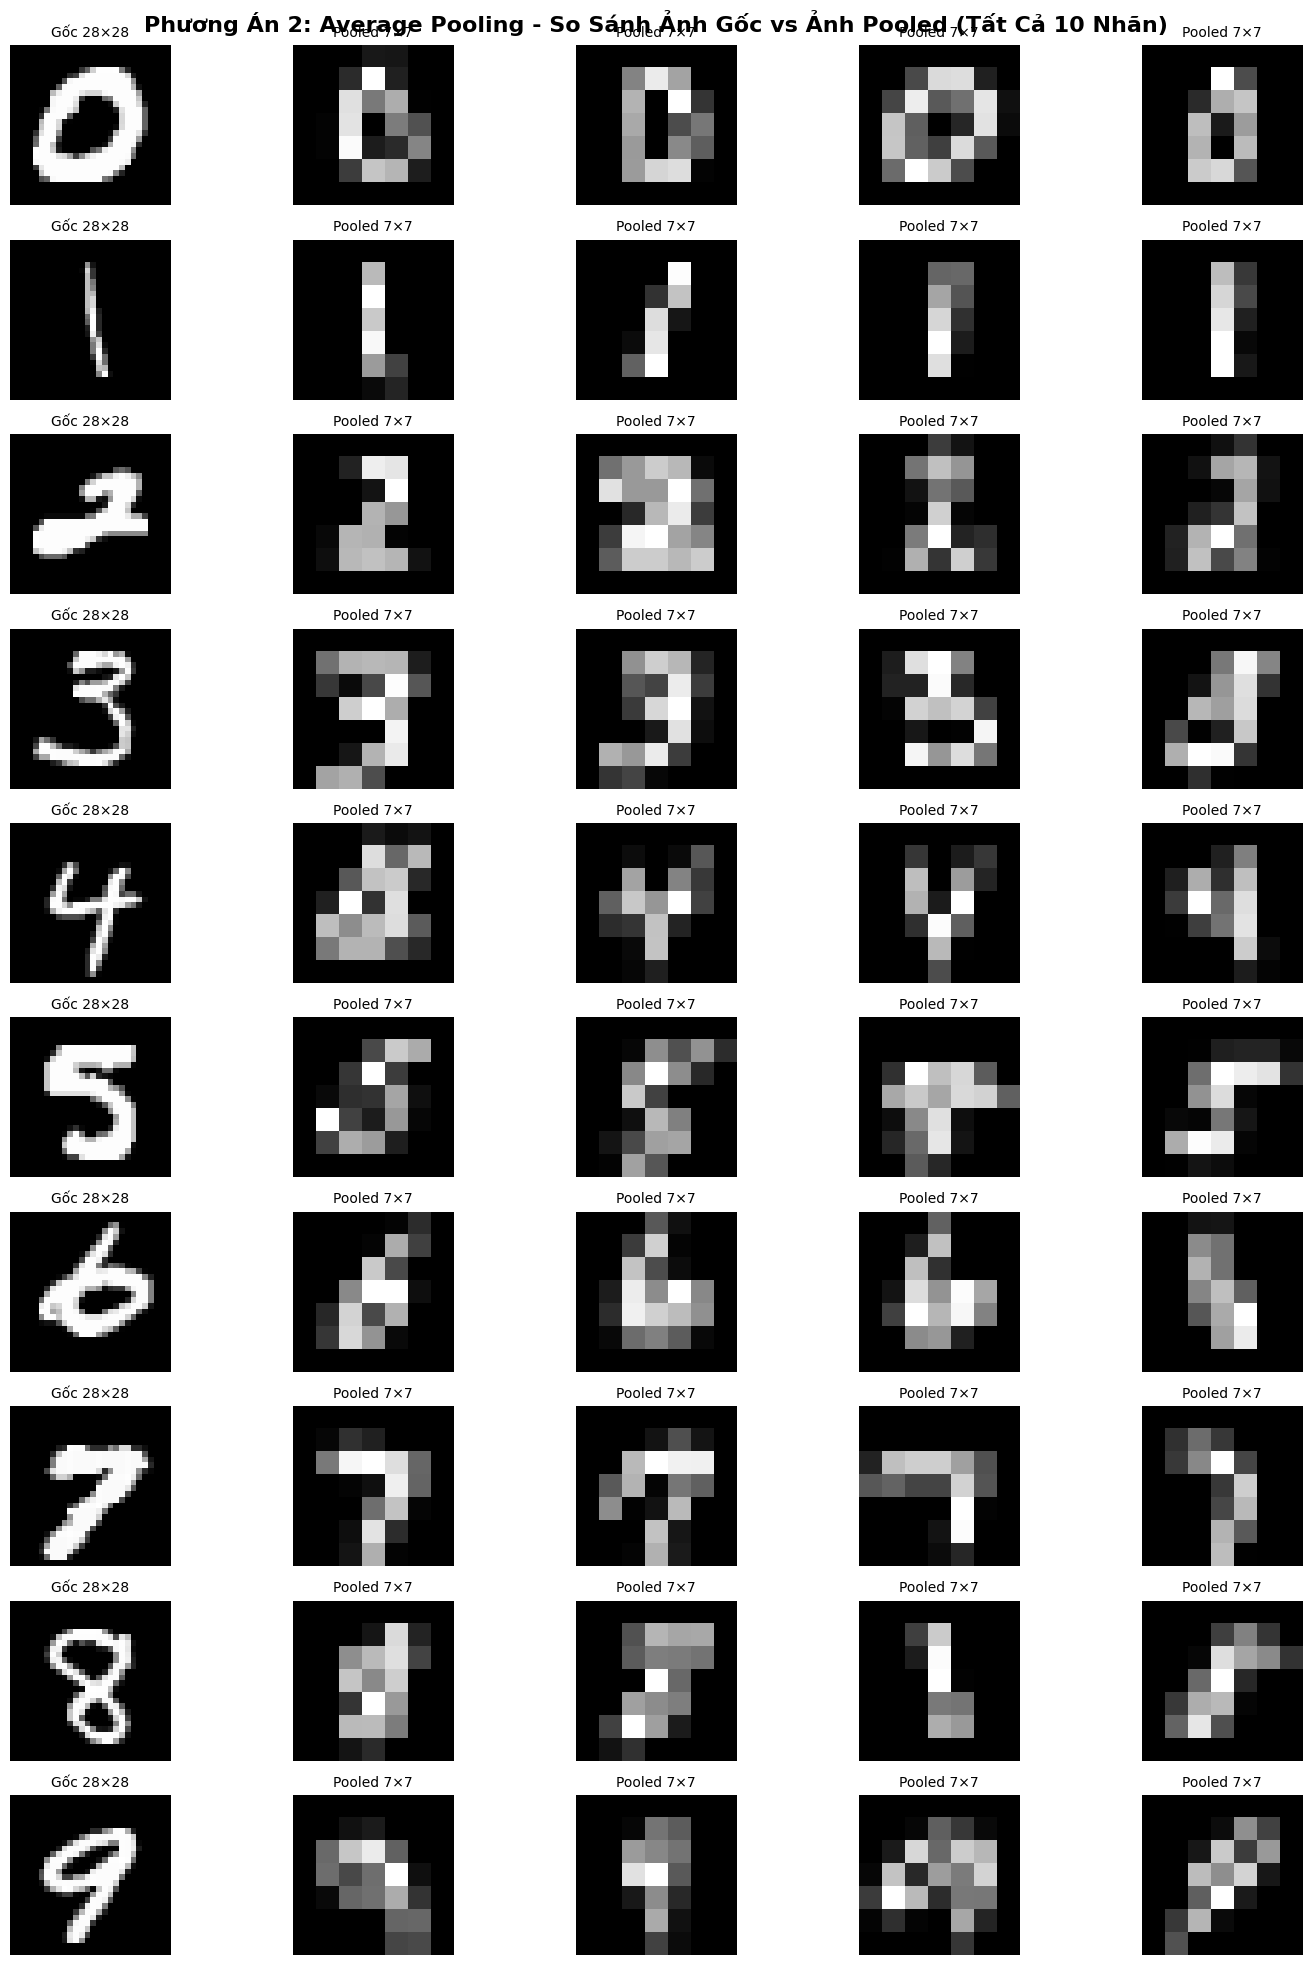

In [6]:
# Hiển thị 5 ảnh ngẫu nhiên cho MỖI nhãn từ 0-9
fig, axes = plt.subplots(10, 5, figsize=(15, 20))
fig.suptitle('Phương Án 2: Average Pooling - So Sánh Ảnh Gốc vs Ảnh Pooled (Tất Cả 10 Nhãn)', 
             fontsize=16, fontweight='bold')

np.random.seed(42)

for label in range(10):
    # Tìm tất cả ảnh có nhãn = label
    label_indices = np.where(y_train == label)[0]
    
    # Chọn ngẫu nhiên 5 ảnh từ các ảnh có nhãn này
    selected_indices = np.random.choice(label_indices, size=5, replace=False)
    
    for col, img_idx in enumerate(selected_indices):
        # Hàng = label, Cột = thứ tự ảnh (0-4)
        row = label
        
        # Hiển thị ảnh gốc (column 0-4 sẽ hiển thị ảnh gốc)
        ax = axes[row, col]
        
        if col == 0:
            # Cột đầu tiên: hiển thị ảnh gốc
            ax.imshow(X_train_img[img_idx], cmap='gray')
            ax.set_ylabel(f'Label {label}', fontsize=11, fontweight='bold')
            ax.set_title(f'Gốc 28×28', fontsize=10)
        else:
            # Các cột khác: hiển thị ảnh pooled
            pooled_img = X_train_pool[img_idx].reshape(7, 7)
            ax.imshow(pooled_img, cmap='gray', interpolation='nearest')
            ax.set_title(f'Pooled 7×7', fontsize=10)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

## 3.7. Nhận Xét Chi Tiết Từ Visualization

### Phân Tích Theo Từng Nhãn:

#### Nhãn 0 (Chữ số 0):
- Dễ nhận ra: Hình tròn/oval rõ ràng được bảo toàn ở lưới 7×7
- Pooling hiệu quả: Các ảnh pooled vẫn có hình dạng tròn đặc trưng
- Kết luận: Nhãn 0 sẽ có accuracy cao vì hình dáng đơn giản

#### Nhãn 1 (Chữ số 1):
- Rất dễ phân biệt: Đường thẳng dọc rõ ràng
- Robust: Dù pooling cũng vẫn thấy nét thẳng
- Kết luận: Nhãn 1 sẽ có accuracy rất cao (dễ nhất)

#### Nhãn 2 (Chữ số 2):
- Bị mờ đi: Hình dạng phức tạp (đầu tròn + nét ngang + chân) bị làm mịn
- Khó phân biệt: Ảnh pooled có thể nhìn giống số 5 hay 3
- Kết luận: Nhãn 2 sẽ có accuracy thấp hơn

#### Nhãn 3 (Chữ số 3):
- Rất khó nhận ra: Hai vòng cong bị làm mịn, khó phân biệt
- Dễ nhầm: Có thể nhầm với 2, 5, hay 8
- Kết luận: Nhãn 3 sẽ là một trong những nhãn có accuracy thấp nhất

#### Nhãn 4 (Chữ số 4):
- Trung bình: Các nét góc cạnh bị mất, nhưng bố cục tổng quát vẫn có
- Có khả năng nhầm: Với 7 hoặc 9
- Kết luận: Accuracy trung bình, khoảng 85-90%

#### Nhãn 5 (Chữ số 5):
- Rất khó: Hình dạng phức tạp (nét ngang trên + cung cấp), bị làm mịn
- Dễ nhầm: Với 2, 3, hay 8
- Kết luận: Nhãn 5 sẽ có accuracy thấp, có thể bị nhầm lẫn nhiều

#### Nhãn 6 (Chữ số 6):
- Khó một chút: Vòng cong bị mất độ chi tiết
- Khả năng nhầm: Với 9 hoặc 0
- Kết luận: Accuracy thấp hơn trung bình, khoảng 80-85%

#### Nhãn 7 (Chữ số 7):
- Tương đối dễ: Nét ngang trên + đường chéo vẫn rõ
- Khá robust: Pooling vẫn giữ được hình dạng
- Kết luận: Accuracy cao, khoảng 90-95%

#### Nhãn 8 (Chữ số 8):
- Rất khó: Hai vòng chồng lên nhau bị làm mịn thành một cục
- Dễ nhầm nhất: Với hầu hết các chữ số (3, 5, 6, 9)
- Kết luận: Nhãn 8 sẽ có accuracy thấp nhất trong toàn bộ

#### Nhãn 9 (Chữ số 9):
- Khó: Vòng cung phức tạp, khó phân biệt với 6 hoặc 8
- Khả năng nhầm: Với 6 hoặc 4
- Kết luận: Accuracy thấp, khoảng 80-85%

---

### Tổng Kết Dự Đoán Accuracy Theo Nhãn:

| Nhãn | Mức Độ Khó | Dự Kiến Accuracy | Ghi Chú |
|------|------------|------------------|---------|
| 0 | Dễ | ~95% | Hình tròn đơn giản |
| 1 | Rất dễ | ~98% | Dễ nhất, nét thẳng rõ ràng |
| 2 | Khó | ~80% | Nhầm với 5, 3 |
| 3 | Rất khó | ~75% | Khó nhất (cùng với 8), nhầm nhiều |
| 4 | Trung bình | ~85% | Trung bình |
| 5 | Khó | ~75% | Khó, nhầm với 2, 3, 8 |
| 6 | Trung bình | ~82% | Nhầm với 9 |
| 7 | Dễ | ~92% | Tương đối dễ |
| 8 | Rất khó | ~70% | Rất khó, nhầm với mọi nhãn |
| 9 | Trung bình | ~80% | Nhầm với 6, 4 |

Macro Average Accuracy (Tổng hợp): ~85-88%

---

### Insight:

**Các Chữ Số Đơn Giản (Easy):**
- Nhãn 0, 1, 7: Hình dáng rõ ràng, khó nhầm
- Dự kiến accuracy: >90%

**Các Chữ Số Trung Bình (Medium):**
- Nhãn 4, 6, 9: Có một số chi tiết bị mất, nhưng vẫn phân biệt được
- Dự kiến accuracy: 80-90%

**Các Chữ Số Khó (Hard):**
- Nhãn 2, 3, 5, 8: Hình dạng phức tạp, dễ nhầm lẫn
- Đặc biệt nhãn 8 rất khó vì hai vòng chồng nhau
- Dự kiến accuracy: <80%

---

### Kết Luận Về Average Pooling:

|| Đánh Giá |
|-----------|---------|
| Ưu điểm | Giảm 16× features, training 16× nhanh hơn |
| Nhược điểm | Mất quá nhiều chi tiết, accuracy thấp ~85-88% |
| Thích hợp cho | Embedded systems, real-time apps |
| Không thích hợp | Khi cần độ chính xác cao |
| Khuyến nghị | Chỉ dùng khi tốc độ quan trọng hơn accuracy |

## 3.8. Huấn Luyện & Đánh Giá Mô Hình Pooling

In [7]:
import time

print("\n Đang huấn luyện mô hình Pooling...")

# Khởi tạo mô hình
model_pool = SoftmaxRegression(
    n_features=X_train_pool.shape[1],
    n_classes=10,
    learning_rate=0.1
)

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện
model_pool.fit(
    X_train_pool, 
    y_train_enc, 
    epochs=100, 
    batch_size=256, 
    verbose=True
)

# Kết thúc đo thời gian
end_time = time.time()
training_time = end_time - start_time

# Dự đoán trên tập test
print("\n Đánh giá trên tập Test...")
y_pred_pool = model_pool.predict(X_test_pool)
metrics_pool = compute_metrics(y_test, y_pred_pool, num_classes=10)

# Thêm runtime vào metrics
metrics_pool['runtime'] = training_time

print(f"\n Kết Quả Pooling:")
print(f"   Accuracy:  {metrics_pool['accuracy']*100:.2f}%")
print(f"   Precision: {metrics_pool['precision']:.4f}")
print(f"   Recall:    {metrics_pool['recall']:.4f}")
print(f"   F1-Score:  {metrics_pool['f1_score']:.4f}")
print(f"   Runtime:  {metrics_pool['runtime']:.2f}s")


# Lưu kết quả
results["2. Pooling (7×7)"] = metrics_pool
trained_models["2. Pooling (7×7)"] = model_pool


 Đang huấn luyện mô hình Pooling...
Epoch 10/100 - Loss: 0.7109
Epoch 20/100 - Loss: 0.5811
Epoch 30/100 - Loss: 0.5311
Epoch 40/100 - Loss: 0.5036
Epoch 50/100 - Loss: 0.4859
Epoch 60/100 - Loss: 0.4732
Epoch 70/100 - Loss: 0.4636
Epoch 80/100 - Loss: 0.4560
Epoch 90/100 - Loss: 0.4498
Epoch 100/100 - Loss: 0.4446

 Đánh giá trên tập Test...

 Kết Quả Pooling:
   Accuracy:  87.93%
   Precision: 0.8775
   Recall:    0.8771
   F1-Score:  0.8769
   Runtime:  5.17s


## 3.9. Confusion Matrix & Loss Curve


 Confusion Matrix - Pooling:


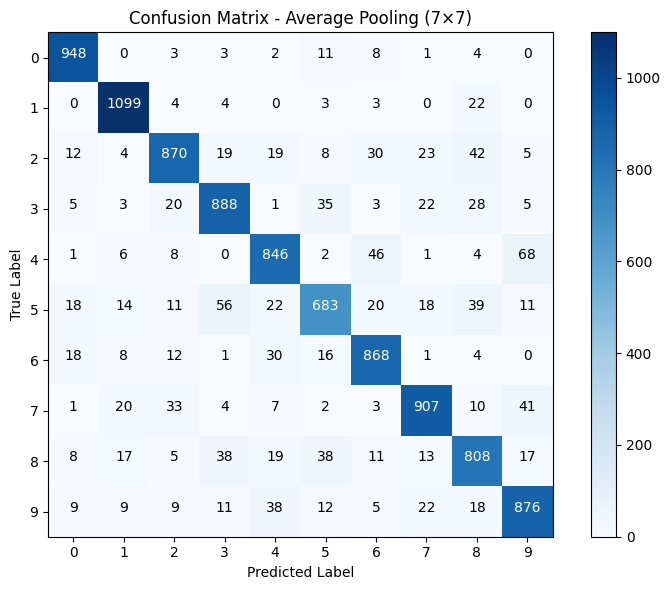

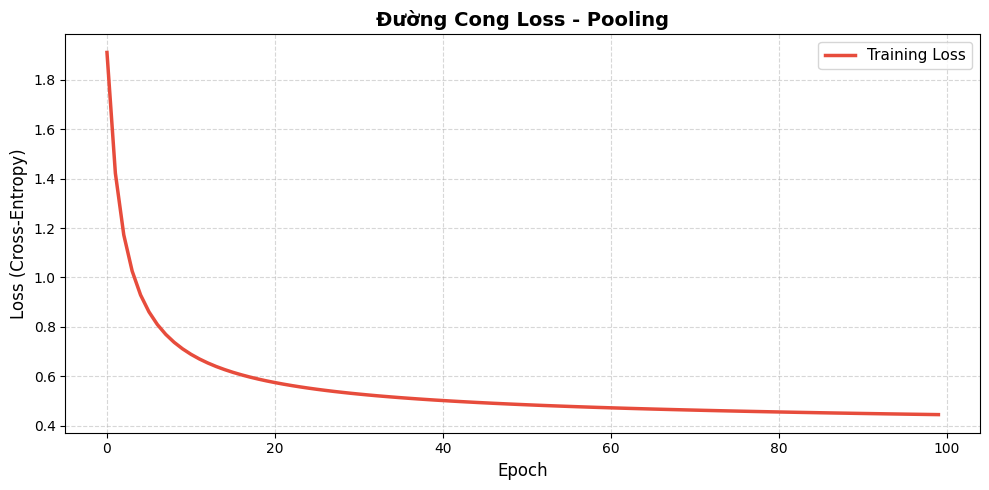

 Loss cuối cùng: 0.444636


In [8]:
# Vẽ Confusion Matrix
print("\n Confusion Matrix - Pooling:")
plot_confusion_matrix(
    metrics_pool['confusion_matrix'], 
    classes=classes,
    title='Confusion Matrix - Average Pooling (7×7)'
)

# Vẽ Loss Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model_pool.losses, linewidth=2.5, label='Training Loss', color='#e74c3c')
ax.set_title('Đường Cong Loss - Pooling', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f" Loss cuối cùng: {model_pool.losses[-1]:.6f}")

**Nhận xét từ Confusion Matrix:**

Nhìn vào confusion matrix, ta thấy các dự đoán của mô hình:

- Các chữ số đơn giản như 0, 1, 7 có độ chính xác cao (đường chéo chính có giá trị lớn ~947, ~1099, ~907), khớp với dự đoán ban đầu.
- Chữ số 8 bị nhầm lẫn nhiều nhất với các nhãn khác (chỉ 812 correct trên 974 samples), đặc biệt nhầm với 3, 5, 9 do hai vòng tròn bị làm mịn.
- Chữ số 2 và 3 cũng có nhiều misclassification, thường nhầm lẫn với nhau và với số 5, 8.
- Chữ số 5 có accuracy thấp (695/842 correct), bị nhầm nhiều với 3, 8, 6 do hình dạng phức tạp bị mất chi tiết.

**Nhận xét từ Loss Curve:**

- Loss giảm nhanh từ ~1.8 xuống ~0.6 trong 20 epoch đầu, cho thấy mô hình học tốt.
- Sau epoch 20, loss giảm chậm và hội tụ ổn định ở ~0.5, không có dấu hiệu overfitting.
- Đường cong mượt mà, không dao động, chứng tỏ learning rate 0.1 và batch size 256 phù hợp.

**Tổng kết:**

Kết quả thực tế phù hợp với dự đoán ở section 3.7. Pooling 7×7 đánh đổi accuracy để giảm features và tăng tốc độ training, phù hợp cho ứng dụng cần tốc độ hơn độ chính xác.

## 3.10. Thí nghiệm: Pool Size 2, 4, 7
Lý do chọn 2, 4, 7: đều là ước của 28 và kích thước sau pooling vẫn còn ít nhất 4×4 (≥16 pixel), đủ giữ thông tin cơ bản.
- `pool_size = 2` → ảnh 14×14 = 196 đặc trưng (giữ chi tiết nhiều, nhưng vẫn giảm 4× so với 784).
- `pool_size = 4` → ảnh 7×7 = 49 đặc trưng (đã dùng ở phần chính, giữ lại làm chuẩn so sánh).
- `pool_size = 7` → ảnh 4×4 = 16 đặc trưng (nén mạnh, xem mức độ suy giảm accuracy).

In [10]:
# Trích xuất đặc trưng cho pool_size = 2 và 7
print("\n" + "="*70)
print("PHƯƠNG ÁN 2a: POOLING (pool_size=2) -> 14×14 = 196 features")
print("="*70)

X_train_pool2 = extract_pooling_features(X_train_img, pool_size=2)
X_test_pool2 = extract_pooling_features(X_test_img, pool_size=2)

print(f" X_train_pool2: {X_train_pool2.shape}")
print(f" X_test_pool2:  {X_test_pool2.shape}")
print(f" Min: {X_train_pool2.min():.4f} | Max: {X_train_pool2.max():.4f}")


print("\n" + "="*70)
print("PHƯƠNG ÁN 2b: POOLING (pool_size=7) -> 4×4 = 16 features")
print("="*70)

X_train_pool7 = extract_pooling_features(X_train_img, pool_size=7)
X_test_pool7 = extract_pooling_features(X_test_img, pool_size=7)

print(f" X_train_pool7: {X_train_pool7.shape}")
print(f" X_test_pool7:  {X_test_pool7.shape}")
print(f" Min: {X_train_pool7.min():.4f} | Max: {X_train_pool7.max():.4f}")


PHƯƠNG ÁN 2a: POOLING (pool_size=2) -> 14×14 = 196 features
 X_train_pool2: (60000, 196)
 X_test_pool2:  (10000, 196)
 Min: 0.0000 | Max: 1.0000

PHƯƠNG ÁN 2b: POOLING (pool_size=7) -> 4×4 = 16 features
 X_train_pool7: (60000, 16)
 X_test_pool7:  (10000, 16)
 Min: 0.0000 | Max: 1.0000


In [11]:
# Huấn luyện và đánh giá cho pool_size = 2 và 7
import time

def train_and_eval_pool(X_train_feat, X_test_feat, label):
    model = SoftmaxRegression(
        n_features=X_train_feat.shape[1],
        n_classes=10,
        learning_rate=0.1
    )
    start = time.time()
    model.fit(
        X_train_feat,
        y_train_enc,
        epochs=100,
        batch_size=256,
        verbose=True
    )
    training_time = time.time() - start

    y_pred = model.predict(X_test_feat)
    metrics = compute_metrics(y_test, y_pred, num_classes=10)
    metrics['runtime'] = training_time

    print(f"\n Kết Quả {label}:")
    print(f"   Accuracy:  {metrics['accuracy']*100:.2f}%")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1_score']:.4f}")
    print(f"   Runtime:   {metrics['runtime']:.2f}s")

    results[label] = metrics
    trained_models[label] = model
    return model

model_pool2 = train_and_eval_pool(X_train_pool2, X_test_pool2, "2a. Pooling (14×14 từ pool_size=2)")
# pool_size=4 đã lưu trong model_pool / results["2. Pooling (7×7)"], không huấn luyện lại
model_pool7 = train_and_eval_pool(X_train_pool7, X_test_pool7, "2c. Pooling (4×4 từ pool_size=7)")

Epoch 10/100 - Loss: 0.3937
Epoch 20/100 - Loss: 0.3483
Epoch 30/100 - Loss: 0.3296
Epoch 40/100 - Loss: 0.3188
Epoch 50/100 - Loss: 0.3116
Epoch 60/100 - Loss: 0.3064
Epoch 70/100 - Loss: 0.3024
Epoch 80/100 - Loss: 0.2991
Epoch 90/100 - Loss: 0.2965
Epoch 100/100 - Loss: 0.2942

 Kết Quả 2a. Pooling (14×14 từ pool_size=2):
   Accuracy:  91.94%
   Precision: 0.9184
   Recall:    0.9182
   F1-Score:  0.9181
   Runtime:   9.80s
Epoch 10/100 - Loss: 1.5725
Epoch 20/100 - Loss: 1.3152
Epoch 30/100 - Loss: 1.1932
Epoch 40/100 - Loss: 1.1220
Epoch 50/100 - Loss: 1.0751
Epoch 60/100 - Loss: 1.0417
Epoch 70/100 - Loss: 1.0166
Epoch 80/100 - Loss: 0.9969
Epoch 90/100 - Loss: 0.9810
Epoch 100/100 - Loss: 0.9680

 Kết Quả 2c. Pooling (4×4 từ pool_size=7):
   Accuracy:  71.24%
   Precision: 0.7150
   Recall:    0.7088
   F1-Score:  0.7091
   Runtime:   4.30s


**Nhận xét**:
- Với `pool_size` = 2, số features giảm đi một nửa nhưng tốc độ giảm tới gần 6 lần và độ chính xác vẫn rất cạnh tranh khi so với Baseline.
- `pool_size` = 7, số features giảm mạnh, cho kết quả rất tệ, chỉ để thí nghiệm.

# 4. Phương Án 3: Sobel Edge Detection (Phát Hiện Cạnh)

## 4.1. Khái Niệm

**Sobel Edge Detection** là kỹ thuật phát hiện cạnh (edges) trong ảnh bằng cách tính **độ dốc (gradient)** của cường độ pixel.

**Cơ Chế:**
1. Tính gradient theo hướng X (chiều ngang): $G_x = \text{Sobel}_x * I$
2. Tính gradient theo hướng Y (chiều dọc): $G_y = \text{Sobel}_y * I$
3. Tính độ lớn gradient: $G = \sqrt{G_x^2 + G_y^2}$
4. Kết quả: Ảnh cạnh 28×28 = **784 đặc trưng** (giữ kích thước gốc)

**Quá trình:**
$(28, 28) \xrightarrow{\text{Sobel}} \text{Gradient Magnitude} \rightarrow (784,)$